In [17]:
import requests
import pandas as pd

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

params = {
    "format": "geojson",
    "starttime": "2013-01-01",
    "endtime": "2024-10-28",
    "minmagnitude": 4,
    "maxmagnitude": 10,
    "minlatitude": 24.0,
    "maxlatitude": 45.5,
    "minlongitude": 122.0,
    "maxlongitude": 153.0
}


response = requests.get(url, params=params)

if response.status_code == 200:

    data = response.json()

    earthquake = pd.json_normalize(data['features'])


    earthquake = earthquake[['properties.time', 'properties.place', 'properties.mag', 'geometry.coordinates']]
    earthquake['properties.time'] = pd.to_datetime(earthquake['properties.time'], unit='ms')


    # earthquake.to_csv("earthquake.csv", index=False)

else:
    print("요청 실패, 상태 코드:", response.status_code)
    print("오류 메시지:", response.text)


In [44]:
earthquake_data = earthquake.copy()

In [45]:
len(earthquake_data)

13600

In [46]:
earthquake_data.columns = ['date', 'location', 'magnitude', 'coordinates']
# earthquake_data = earthquake_data.set_index('date')

In [47]:
earthquake_data = earthquake_data.loc[earthquake_data['location'] == 'Izu Islands, Japan region', ['date','magnitude', 'location']]

In [22]:
earthquake_data['date'] = earthquake_data['date'].astype(str)
earthquake_data['date'] = earthquake_data['date'].apply(lambda x: x[:11])

In [23]:
earthquake_data['date'] = pd.to_datetime(earthquake_data['date'])
earthquake_data['date'] = earthquake_data['date'].dt.floor('D')

In [24]:
earthquake_data = earthquake_data.groupby('date')['magnitude'].mean().reset_index()
earthquake_data = earthquake_data.set_index('date')

In [25]:
full_range = pd.date_range(start=earthquake_data.index.min(),
                           end=earthquake_data.index.max(), freq='D')

# 전체 날짜 범위를 인덱스로 하는 새로운 데이터프레임 생성
full_data = pd.DataFrame(index=full_range)

# 기존 데이터와 병합하여 빠진 날짜는 NaN으로 채워짐
earthquake_data = full_data.join(earthquake_data)

In [26]:
earthquake_data['magnitude'] = earthquake_data['magnitude'].fillna(0)
# earthquake_data['magnitude'] = earthquake_data['magnitude'].interpolate(method='linear')

In [27]:
earthquake_data

,magnitude
2013-01-02,4.6
2013-01-03,0.0
2013-01-04,0.0
2013-01-05,0.0
2013-01-06,0.0
...,...
2024-10-21,0.0
2024-10-22,0.0
2024-10-23,4.7
2024-10-24,0.0


<Axes: >

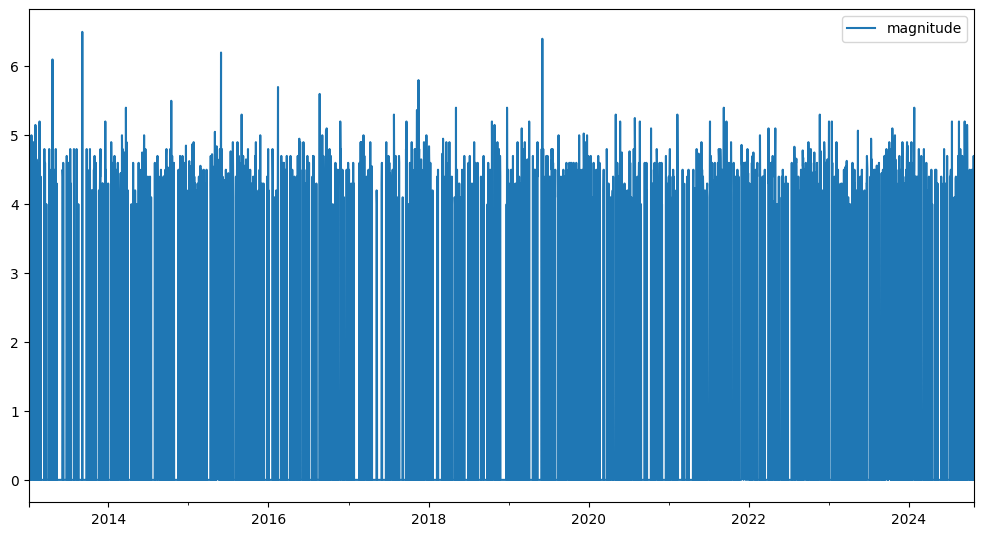

In [28]:
earthquake_data.plot(figsize=(12.2, 6.4))

In [29]:
earthquake_data.columns

Index(['magnitude'], dtype='object')

In [30]:
from statsmodels.tsa.stattools import adfuller

print('ADF test with earthquake time-series')
ADF_result = adfuller(earthquake_data['magnitude'])
#ADF 통계량
print('ADF Stats: %f' % ADF_result[0])
#p-값
print('p-value: %f' % ADF_result[1])
#임계값
print('Critical values:' )
for key, value in ADF_result[4].items():
    print('\t%s: %.4f' % (key, value))

ADF test with earthquake time-series
ADF Stats: -10.702666
p-value: 0.000000
Critical values:
	1%: -3.4319
	5%: -2.8622
	10%: -2.5671


In [31]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(earthquake_data['magnitude'].values.reshape(-1,1))



In [32]:
def load_data(data, seq_len):
    X = []
    y = []

    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i, 0])
        y.append(data[i, 0])
    return X, y

In [33]:
seq_len = 30
X, y = load_data(scaled_data, seq_len)

In [34]:
num = int(len(scaled_data) * 0.8)
num

3452

In [35]:
X_train = X[:num]
y_train = y[:num]
X_test = X[num:]
y_test = y[num:]

import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (len(X_train), seq_len, 1))
X_test = np.reshape(X_test, (len(X_test), seq_len, 1))

In [36]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3452, 30, 1)
y_train.shape =  (3452,)
x_test.shape =  (833, 30, 1)
y_test.shape =  (833,)


In [37]:
import tensorflow as tf
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, Bidirectional
from keras.models import Sequential

model_lstm = Sequential()

model_lstm.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(44, activation='tanh', return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(24, activation='tanh'))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 44)              │          19,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24)                  │           6,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,965 (167.83 KB)

 Trainable params: 42,965 (167.83 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 모델 컴파일
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 모델 훈련
history = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,  # 훈련 데이터의 20%를 검증용으로 사용
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0926 - mean_absolute_error: 0.2276 - val_loss: 0.0930 - val_mean_absolute_error: 0.2488
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0829 - mean_absolute_error: 0.2334 - val_loss: 0.0911 - val_mean_absolute_error: 0.2608
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0807 - mean_absolute_error: 0.2285 - val_loss: 0.0927 - val_mean_absolute_error: 0.2492
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0849 - mean_absolute_error: 0.2393 - val_loss: 0.0911 - val_mean_absolute_error: 0.2649
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0836 - mean_absolute_error: 0.2389 - val_loss: 0.0910 - val_mean_absolute_error: 0.2692
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0792 - mean_absolute_error: 0.2290 - val_loss: 0.0912 - val_mean_absolute_error: 0.2771
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0838 - mean_absolute_error: 0.2436 - val_loss

In [39]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lstmPredict = model_lstm.predict(X_test)
lstmScore = r2_score(y_test, lstmPredict)
print("R2 Score : ", lstmScore)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, lstmPredict)
print("MAE: ", mae)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, lstmPredict)
print("MSE: ", mse)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
R2 Score :  0.010574628981182221
MAE:  0.28025938922007937
MSE:  0.09818536355962625


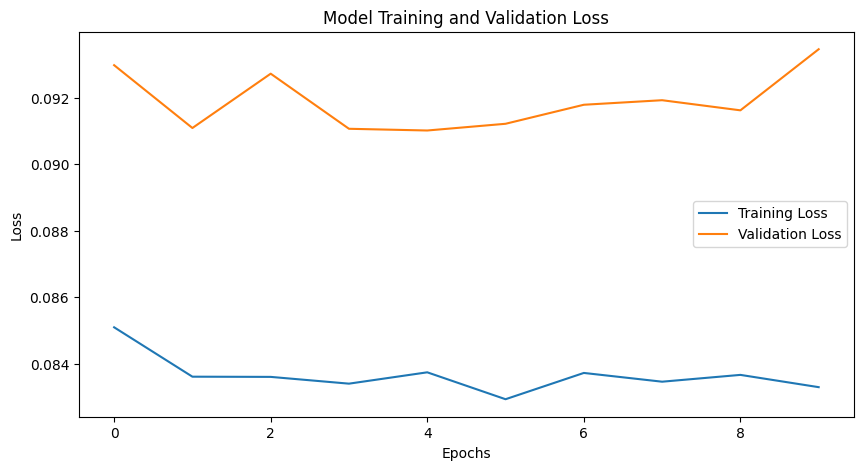

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# 훈련 손실 및 검증 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [41]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.9 MB/s eta 0:00:00


In [42]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# 데이터 준비 (예: X_train이 시계열 데이터로 가정)
# 예시로, X_train을 Pandas Series로 정의합니다.
# 예: X_train = pd.Series(your_time_series_data)

# Auto-ARIMA를 통해 최적의 p, d, q 값 찾기
X_train = pd.Series(scaled_data.flatten(), index=earthquake_data.index)

# auto_model = auto_arima(X_train, seasonal=False, trace=True, stepwise=True)
# print("Auto-ARIMA 모델 요약:")
# print(auto_model.summary())

# # Auto-ARIMA에서 선택된 최적의 p, d, q 값 가져오기
# p, d, q = auto_model.order
# print(f"최적의 (p, d, q) 값: ({p}, {d}, {q})")

# ARIMA 모델을 Auto-ARIMA로 찾은 최적의 p, d, q 값으로 학습
model_arima = ARIMA(X_train, order=(2, 1, 1))
model_arima_fit = model_arima.fit()

# 모델 요약 출력
print("ARIMA 모델 요약:")
print(model_arima_fit.summary())

# 예측 (테스트 데이터 길이만큼 예측을 수행)
# 예를 들어, X_test가 테스트 데이터라고 가정
# steps는 예측할 기간을 설정 (예: len(X_test))
forecast = model_arima_fit.forecast(steps=30)

forecast_reshaped = np.array(forecast).reshape(-1, 1)
original_data = scaler.inverse_transform(forecast_reshaped)

# 예측 결과 출력
print("예측 결과:")
print(original_data)


ARIMA 모델 요약:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4315
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -836.198
Date:                Wed, 06 Nov 2024   AIC                           1680.395
Time:                        01:17:02   BIC                           1705.874
Sample:                    01-02-2013   HQIC                          1689.392
                         - 10-25-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0938      0.014      6.504      0.000       0.066       0.122
ar.L2          0.0636      0.015      4.275      0.000       0.034       0.093
ma.L1         -0.9879      0.002   -414

In [43]:
all_data

NameError: name 'all_data' is not defined